In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
import os
from model_utils import *
import matplotlib.dates as dates

#from iri2016 import timeprofile, timeprofile2

In [ ]:
def GetMatrix(directory, filename, PlotFlag, plot_format, intFactor):
    hour_f= 19.0
    hour_i = 7.0
    h_min = 130#90.0
    h_max = 190#1008.75
    delta_ran = 1.5
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/']['range']
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = np.array(hf['Data/Array Layout/2D Parameters/snl']).T
    vipe1 = np.array(hf['Data/Array Layout/2D Parameters/vipe']).T 
    vipn1 = np.array(hf['Data/Array Layout/2D Parameters/vipn']).T
    v_zonal = np.array(vipe1).T
    v_vertical = np.array(vipn1).T
    snl2 = np.array(snl2)
    if ('Data/Table Layout/vipn' not in hf):
        #print("Funcionó")
        aux_list = list(vipn1.flatten())
        vvert = np.array([i for i in aux_list if not np.isnan(i)])
    else:
        vvert = hf['Data/Table Layout/']['vipn']
    #vvert = hf['Data/Table Layout/']['vipn']
    print("vvert corregido: ", vvert.shape)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    prev_stamps = []
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
    day = index[0].day
    anio = index[0].year
    month = index[0].month
    mes = GetMonth(month)
    ran_max = max(rango)
    ran_min = min(rango)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    DriftMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    string_date = index[0].strftime('%B %d, %Y, %r')
    month_prime = index[0].month
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    time_range, range_fixed = GetTimeRangeArrays(anio, month_prime, dia, hour_i, hour_f,h_min,h_max,delta_ran,intFactor)

    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    countMat = np.zeros(DataMatrix.shape)
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    #Filtering out on SNR and vertical drifts:
        if ((snl[k]>-3.0)): #and vvert[k]<=20):
    # Putting snr in corresponding matrix element
            DataMatrix[row,col] = snl[k]
            DriftMatrix[row,col] = vvert[k]
            countMat[row,col]+=1
        else:
            DataMatrix[row,col] = np.nan
            DriftMatrix[row,col] = np.nan
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix.T#[::-1]
    v_vert = DriftMatrix.T
 
    print("Dimensiones: ", datetime_objects.shape, range_array.shape, data.shape)
    print(time_range.shape, range_fixed.shape)
    ##########################################################################################
    ############################################################################################
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 7)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=intFactor*60),dtype=int)
    m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
    counts = np.diff(np.flatnonzero(m))
    unq = dt_indices[m[:-1]]
    times_repeated=np.c_[unq,counts] 
    time_range_index = np.arange(0,720/intFactor)

    
    d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    v_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    for j in range(data.shape[1]):
    
        for i in range(times_repeated.shape[0]):
            if i==0:
                d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
                v_prom[i,j] = np.nanmean(v_vert[0:times_repeated[0,1],j])
            else:
                aux = np.sum(times_repeated[0:i,1])
                aux2 = times_repeated[i,1]
                d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
                v_prom[i,j] = np.nanmean(v_vert[aux:aux+aux2,j])
    index_aux = times_repeated[:,0]
    diff = Diff(time_range_index, index_aux)
    diff=np.array(diff)
    diff=np.sort(diff)
    diff=diff.astype(np.dtype('int64'))
    
    b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan
    v3 = np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan
    print("Shapes: ",time_range.shape, range_fixed.shape, v3.T.shape)

    for j in range(data.shape[1]):
        b_aux=d_prom[:,j]
        v_aux=v_prom[:,j]
        for i in list(diff):
            aux=b_aux[:i]
            aux2=b_aux[i:]
            aux=np.append(aux,np.nan)
            aux=np.append(aux,b_aux[i:])
            b_aux=aux
            
            vaux=v_aux[:i]
            vaux2=v_aux[i:]
            vaux=np.append(vaux,np.nan)
            vaux=np.append(vaux,v_aux[i:])
            v_aux=vaux
            
        b3[:,j]=b_aux
        v3[:,j]=v_aux
    ##########################################################################################
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, v3.T,cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([130,190])
        str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,7)
        str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,18)
        dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])

#dia = dia - 1
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (year, month, day) 
        plt.title(fig_title, fontsize=15)
        str_date = '%d-%02d-%02d' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.savefig('%s/promedio/promedio-%dmin-%s.png' % (dir_plots,intFactor,str_date))
        #'''
        #plt.close(fig)
        fig, ax = plt.subplots(figsize=(12, 6))        
        clrs0 = ax.pcolormesh(datetime_objects,range_array,v_vert.T, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([130,190])
        str_ti = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,8)
        str_tf = '%d-%02d-%02d %02d:00:00' % (time_range[0].year,time_range[0].month,time_range[0].day,17)
        dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
        dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
        ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
        
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(clrs0)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
        plt.savefig(r'%s/derivas-verticales/derivas-verticales-ecos-150km-%dmin-%d-%02d-%02d-SNR.%s' % (dir_plots,intFactor,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)
        #'''
  
        #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.style.use('dark_background')
        clrs = ax.pcolormesh(datetime_objects,range_array,data.T, cmap='jet')
        #ax.pcolormesh(datetime_objects,rango2D,v_zonal.T, cmap='jet')#,vmin=0,vmax=2e11)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(clrs)
        cb4.set_label(r'SNR (dB)', fontsize=15)
        plt.savefig(r'%s/SNR/ecos-150km-%dmin-%d-%02d-%02d-SNR.%s' % (dir_plots,intFactor,anio, month_prime, dia, plot_format))
        plt.show()
        plt.close(fig)   
        #'''
    return  data, index, range_array,dir_plots,datetime_objects, b3, range_fixed, time_range,v_vertical,v3

In [2]:
def GetMatrix_old(directory, filename, PlotFlag, plot_format):
    ##########################################################
    ## 2020-06-16: Se verificó que la función trabaja
    ## correctamente. Se creara una nueva para hacer pruebas 
    ## con las dimensiones
    ##########################################################
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    rango = hf['Data/Table Layout/']['gdalt']
    #rango2D = hf['Data/Array Layout/']['range']
    #Data/Array Layout/timestamps
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = np.array(hf['Data/Array Layout/2D Parameters/snl']).T
      
    vipe1 = np.array(hf['Data/Array Layout/2D Parameters/vipe']).T
    vipn1 = np.array(hf['Data/Array Layout/2D Parameters/vipn']).T
    v_zonal = vipe1
    v_vertical = vipn1
    #snl2 = np.array(snl2)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
        date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
        date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
        time_vector.append(date_string)
        date_list.append(date)
    #####################################################################
    index = pd.DatetimeIndex(date_list) - timedelta(hours=5)
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    prev_stamps = []
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
     ##########################################################
    # Aquí viene la conversión a listas 
    #converted_value = getattr(value, "tolist", lambda: value)()
    days = getattr(days, "tolist", lambda: days)()
    year = getattr(year, "tolist", lambda: year)()
    month = getattr(month, "tolist", lambda: month)()
    hour = getattr(hour, "tolist", lambda: hour)()
    minutes = getattr(minutes, "tolist", lambda: minutes)()
    seconds = getattr(seconds, "tolist", lambda: seconds)()
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_zonal = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_vertical = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    
    string_date = index[0].strftime('%B %d, %Y, %r')
    #line.split()[0]
    #mes = string_date.split()[0]
    month_prime = index[0].month
    #if mes == 'June':
    #    mes ='Junio'
    #if mes == 'July':
    #    mes = 'Julio'
    #if mes == 'August':
    #    mes ='Agosto'
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    
    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    dir_plots_EEJ = 'Plots-150km-%s-%d/EEJ' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix#[::-1]
    
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
        #plt.style.use('dark_background')
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        extent=[x_min, x_max,ran_min,ran_max]
        im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(im2)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 ,ha='center')

        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        im3 = plt.imshow(v_vertical.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=15)
        ax.set_ylabel("Rango (km)", fontsize=15)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=17)
        #ax.set_xlim(90,130)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb3 = fig.colorbar(im3)
        cb3.set_label(r'Velocidad vertical (m/s)', fontsize=15)
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format),bbox_inches="tight")
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.style.use('dark_background')
        #plt.rcParams['xtick.labelsize']=14
        im4 = plt.imshow(v_zonal.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(im4)
        cb4.set_label(r'Velocidad zonal (m/s)', fontsize=15)
        cb4.mappable.set_clim(-20,20)

        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-zonal.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
        ############################################################3
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        im3 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        #ax.set_xlim(90,130)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb3 = fig.colorbar(im3)
        cb3.set_label(r'EEJ', fontsize=15)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/eej-ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    
    return  data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, timestamps, snl2

In [3]:
def GetTimeRangeArrays(year, month, day, hour_i, hour_f, h_min, h_max, delta_ran, intFactor):
    range_fixed = np.arange(h_min,h_max,delta_ran)
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_i)
    string_tf = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_f)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dtf = datetime.datetime.strptime(string_tf, '%Y-%m-%d %H:%M:%S')# + timedelta(days=1)
#ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
    time_range = np.arange(dt0,dtf,timedelta(seconds=intFactor*60)).astype(datetime.datetime)
    print(time_range[1]-time_range[0])
    print("time_range.shape: ", time_range.shape)
    #print("Type: ", type(time_range[0]))
    #time_range = np.array(time_range).astype(datetime.datetime)#,dtype='datetime64[s]')
    return time_range, range_fixed

In [4]:
year = 2022
month = 1
day = 15 
intFactor = 10#10
str_month = GetMonth(month)

In [5]:
current_month = '%s-%d' % (str_month, year)
directory = 'Data-%s/' % current_month
plots_boletin = '/home/juanpablo/Desktop-JRO/Plots-Boletines/%02d/%s' % (year,str_month)
str_format = 'png'
plot_format = str_format
#filename1 ='jul%d%02d%02d_150km.hdf5' % (year,month,day)
filename1 = 'jul%d%02d%02d_150km.001.hdf5' % (year,month,day)
filenameH = '/home/juanpablo/Desktop-JRO/Magnetometer/Enero-2022-Data/Jicamarca/jica_220115.min'
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15


In [7]:
print(vvert.shape, vipn1.shape, datetime_objects.shape)

(2917,) (297, 26) (297,)


In [44]:
print(filename1)

jul20220115_150km.001.hdf5


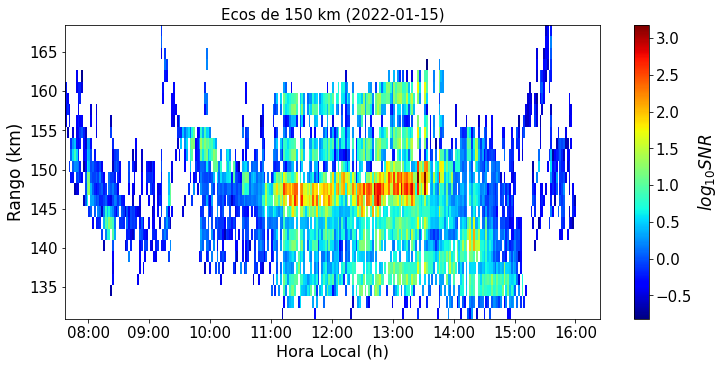

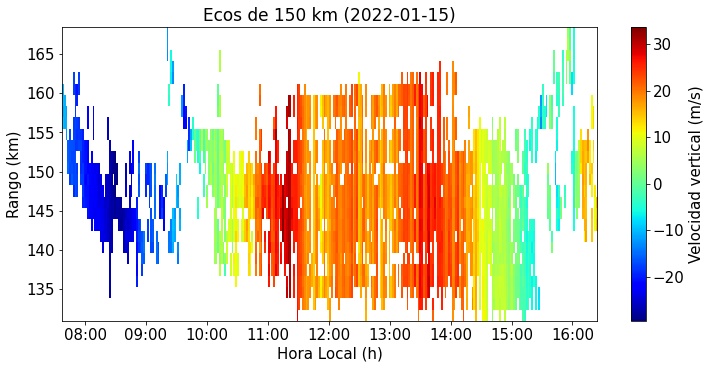

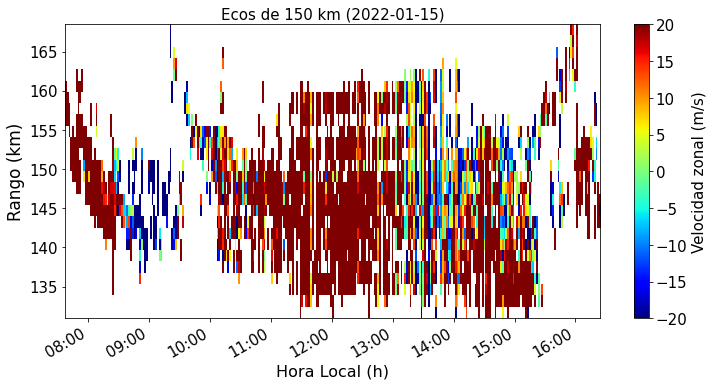

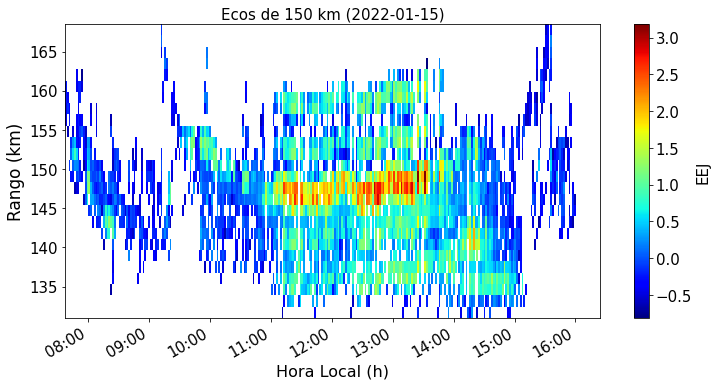

In [48]:
PlotFlag = True
plot_format = 'pdf'
#datetime_objects,range_array, v_vertical = GetMatrix(directory, filename1, PlotFlag, plot_format, intFactor)
data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, timestamps, snl2 = GetMatrix_old(directory, filename1, PlotFlag, plot_format)
#directory, filename, PlotFlag, plot_format

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  # Remove the CWD from sys.path while we load stuff.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

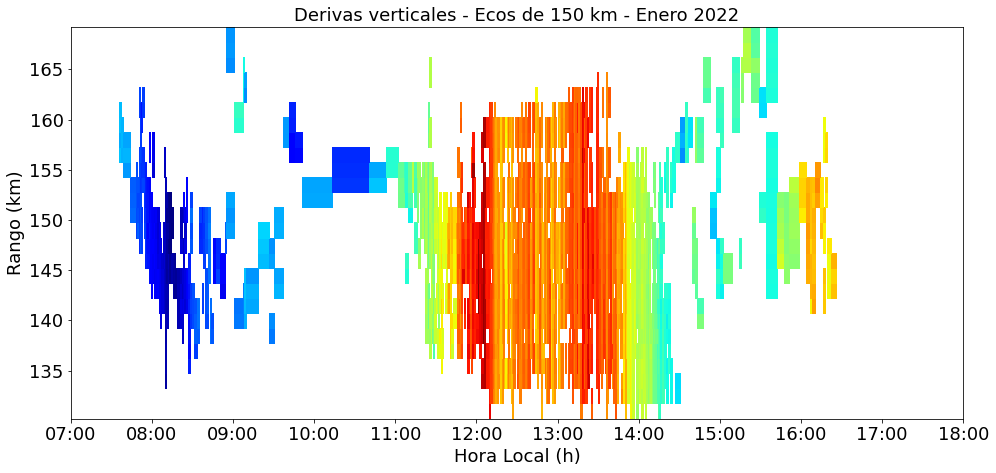

In [79]:
fig, ax = plt.subplots(figsize=(16, 8))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
ran_max = np.max(range_array)+10
ran_min = np.min(range_array)
    #rang_list = list(rango)
x_min = mdates.date2num(np.min(index))
x_max = mdates.date2num(np.max(index))
extent=[x_min, x_max,ran_min,ran_max]
clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, v_vertical.T,cmap='jet', shading='none')#'RdBu_r')#'jet')
#im2 = plt.imshow(v_vertical.T,cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)

#str_ti = '%d-%02d-%02d %02d:00:00' % (datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,7)
#str_tf = '%d-%02d-%02d %02d:00:00' % (datetime_objects[0].year,datetime_objects[0].month,datetime_objects[0].day,18)
dti = datetime.datetime.strptime(str_ti, '%Y-%m-%d %H:%M:%S')
dtf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
ax.set_xlim([dates.date2num(dti),dates.date2num(dtf)])
#fig_title = r'Mapa de Ocurrencias - Ecos de 150 km - %s' % str_month #% (year, month, day) 
fig_title = r'Derivas verticales - Ecos de 150 km - %s %d' % (str_month,year) #% (year, month, day) 

plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
#cb.mappable.set_clim(0,np.max(mat_avg_final))
#cb2 = fig.colorbar(im2)
cb.set_label(r'Derivas verticales (m/s)', fontsize=18)
#cb2.ax.tick_params(labelsize=16)
cb.ax.tick_params(labelsize=16)

#cb.mappable.set_clim(0,np.max(mat_avg_fi))

plot_format = 'png'
str_fig = '%s/filtered-%dmin-mapa-de-ocurrencias-Ecos-de-150km%d-%s-%s.%s' % (plots_boletin,intFactor,year, GetMonth(month),color_palette,plot_format)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0,ha='center' )
#plt.savefig(str_fig,bbox_inches="tight")

In [31]:
#print(prom)